Author: Amparo Godoy Pastore <br>
Date: July 6th, 2024 <br>
Course: Data Mining and Machine Learning <br>

# Exploring Classification and Clustering Methods: A Comprehensive Analysis of Dimensionality Reduction and Performance Evaluation

## Table of Contents
* [1. Preparing the Data](#1)
* [2. Covariance Matrix Analysis](#2) <br>
* [3. Classification Experiment](#3) <br>
      [3.1 KNN](#3-1) <br>
      [3.2 SVM](#3-2) <br>
      [3.3 LDA](#3-3) <br>
      [3.4 Naïve Bayes](#3-4) <br>
      [3.5 Bayes (from scratch)](#3-5) <br>
* [4. Clustering Experiment](#4) <br>
      [4.a Clustering `n_clusters=5` (3 methods)](#4-a) <br>
      [4.b Results, evaluation metrics, and visualization](#4-b) <br>  
* [5. Clustering `n_clusters=2` (3 methods)](#5) <br>
* [6. Test on Five-Stage Classification](#6) <br>
* [Conclusion](#last)

This notebook uses the `Colon.csv` file, which contains gene data from each patient. The dataset includes various gene expression measurements (features) and a label indicating the stage information.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from scipy.stats import multivariate_normal
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## 1. Preparing the Data <a class="anchor" id="1"></a>

The code below loads the `Colon.csv` data and splits it into train and test sets (80/20 %, respectively).

In [2]:
# load 
df = pd.read_csv("Colon.csv")

# get data and labels
X = df.iloc[:, :-1].to_numpy() # data
y = df.iloc[:, -1].to_numpy() # labels

# split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Shape of the Train data: {X_train.shape}")
print(f"Shape of the Test data: {X_test.shape}")

Shape of the Train data: (373, 1881)
Shape of the Test data: (94, 1881)


The code below applies Principal Component Analysis (PCA) and Kernel PCA techniques—using Radial Basis Function (RBF), Polynomial, Linear, and Combined kernels—to transform the training and testing data. PCA simplifies the dataset by identifying patterns and reducing its dimensions, while Kernel PCA enhances this by mapping the data into higher-dimensional spaces defined by different kernels. The transformed data maintains consistency between the training and testing sets, ensuring that the dimensionality reduction applied during training is accurately applied to new, unseen data.

In [3]:
# number of components for PCA and Kernel PCA
n_components = 10  

# Initialize PCA and Kernel PCA models
pca = PCA(n_components=n_components)
kpca_rbf = KernelPCA(n_components=n_components, kernel='rbf', eigen_solver='randomized', max_iter=1000)
kpca_poly = KernelPCA(n_components=n_components, kernel='poly', eigen_solver='randomized', max_iter=1000)
kpca_linear = KernelPCA(n_components=n_components, kernel='linear', eigen_solver='randomized', max_iter=1000)
kpca_combined = KernelPCA(n_components=n_components, kernel='precomputed')

# -------------------Fit train-------------------
X_train_pca = pca.fit_transform(X_train)
X_train_kpca_rbf = kpca_rbf.fit_transform(X_train)
X_train_kpca_poly = kpca_poly.fit_transform(X_train)
X_train_kpca_linear = kpca_linear.fit_transform(X_train)
# for combined kernel...
K_rbf = rbf_kernel(X_train, gamma=1.0)
K_poly = polynomial_kernel(X_train, degree=2.0, coef0=1)
K_combined = K_rbf + K_poly
X_train_kpca_combined = kpca_combined.fit_transform(K_combined)

# -------------------Transform test-------------------
X_test_pca = pca.transform(X_test)
X_test_kpca_rbf = kpca_rbf.transform(X_test)
X_test_kpca_poly = kpca_poly.transform(X_test)
X_test_kpca_linear = kpca_linear.transform(X_test)
# for combined kernel...
K_test_rbf = rbf_kernel(X_test, X_train, gamma=1.0)
K_test_poly = polynomial_kernel(X_test, X_train, degree=2.0, coef0=1)
K_test_combined = K_test_rbf + K_test_poly
X_test_kpca_combined = kpca_combined.transform(K_test_combined)

# check dimensions
print(f"Dimensions after PCA transformation: Train={X_train_pca.shape}, Test={X_test_pca.shape}")
print(f"Dimensions after Kernel PCA (RBF) transformation: Train={X_train_kpca_rbf.shape}, Test={X_test_kpca_rbf.shape}")
print(f"Dimensions after Kernel PCA (Poly) transformation: Train={X_train_kpca_poly.shape}, Test={X_test_kpca_poly.shape}")
print(f"Dimensions after Kernel PCA (Linear) transformation: Train={X_train_kpca_linear.shape}, Test={X_test_kpca_linear.shape}")
print(f"Dimensions after Kernel PCA (Combined) transformation: Train={X_train_kpca_combined.shape}, Test={X_test_kpca_combined.shape}")

Dimensions after PCA transformation: Train=(373, 10), Test=(94, 10)
Dimensions after Kernel PCA (RBF) transformation: Train=(373, 10), Test=(94, 10)
Dimensions after Kernel PCA (Poly) transformation: Train=(373, 10), Test=(94, 10)
Dimensions after Kernel PCA (Linear) transformation: Train=(373, 10), Test=(94, 10)
Dimensions after Kernel PCA (Combined) transformation: Train=(373, 10), Test=(94, 10)


## 2. Covariance Matrix Analysis <a class="anchor" id="2"></a>

The Covariance Matrix Analysis below begins by preparing the data, excluding the last column.
A mean vector is calculated, and the data is centered by subtracting this mean. The covariance matrix is then computed using the formula (1/𝑛) × (centered_data.𝑇 × centered_data), where 𝑛 is the number of observations minus one.


In [4]:
data = df.iloc[:,:-1]
# Calculating mean vector and centering the data
mean_vector = data.mean()
centered_data = data - mean_vector
# Calculating the covariance matrix of the dataset
n = len(centered_data) - 1
covariance_matrix = (1/n) * (centered_data.T @ centered_data)

This matrix is stacked to create a Series of covariance values indexed by feature pairs, which are sorted in descending order. The top 20 feature pairs are identified, and from these, the unique top 10 features are extracted.

In [5]:
# Identifying the top 10 features with the highest covariance
cov_matrix_no_diag = covariance_matrix.where(~np.eye(covariance_matrix.shape[0], dtype=bool)) # Excluding the diagonal

stacked_cov = cov_matrix_no_diag.stack() # Stack the matrix to get a Series of covariance values indexed by pairs of features

sorted_cov_pairs = stacked_cov.sort_values(ascending=False) # Sort in descending order

top_features = pd.unique(sorted_cov_pairs.index.get_level_values(0)[:20].tolist() + sorted_cov_pairs.index.get_level_values(1)[:10].tolist()) # Extract the unique features 
top_features = top_features[:10] # Select the top 10 features

print(top_features)

['hsa-mir-192' 'hsa-mir-148a' 'hsa-mir-22' 'hsa-mir-21' 'hsa-mir-203a'
 'hsa-mir-99b' 'hsa-mir-375' 'hsa-let-7b' 'hsa-mir-200c' 'hsa-mir-10a']


C:\Users\agodo\AppData\Local\Temp\ipykernel_5220\3424987893.py:8: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  top_features = pd.unique(sorted_cov_pairs.index.get_level_values(0)[:20].tolist() + sorted_cov_pairs.index.get_level_values(1)[:10].tolist()) # Extract the unique features


A classifier is trained on the selected top 10 features of the training data and tested on the test data, achieving an accuracy of 31.91%. This process highlights the most significant features based on their covariance.

In [6]:
# Extracting the top 10 features from train and test
top_feature_indices = data.columns.get_indexer(top_features) # get indices

Train_top10 = X_train[:, top_feature_indices]
Test_top10 = X_test[:, top_feature_indices]

## 3. Classification Experiment <a class="anchor" id="3"></a>

The code below tests the classifiers (KNN, Bayes, Naive Bayes, LDA, and SVM) on:
- Whole data
- Data reduced by PCA
- Data reduced by KPCA with RBF, Polynomial, and Linear kernel
- Data reduced by top 10 features

**Results of the experiment**

KNN achieved the highest accuracy of 35.11% using PCA with 9 components, followed by SVM and Bayes classifiers each reaching 35.11% using PCA with 3 components. Using kernel PCA (KPCA), the linear kernel yielded the best results for both KNN and SVM, achieving accuracies of 35.11% and 35.11% respectively. Notably, classifiers performed less effectively on reduced feature sets, with accuracies generally lower than those achieved with PCA transformations.

# KNN <a class="anchor" id="3-1"></a>

In [7]:
# whole data (KNN)
KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.3404255319148936


Best number of components: 9 with accuracy: 0.3511


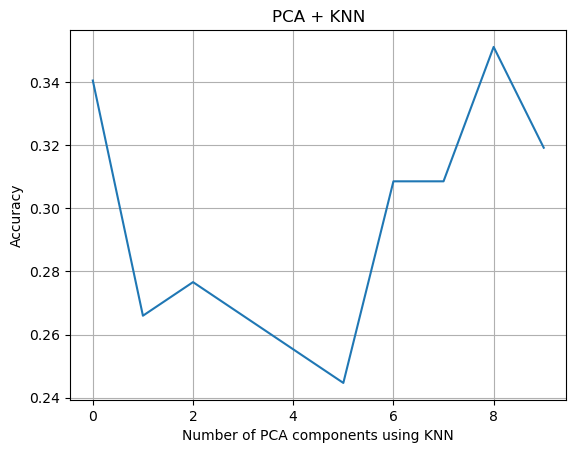

In [8]:
# PCA + KNN
results = []
best_accuracy = 0
best_n_components = 0

for i in range(10):
    pca = PCA(n_components=i+1)
    train_reduced = pca.fit_transform(X_train)
    test_reduced = pca.transform(X_test)
    # train classifier
    KNN = KNeighborsClassifier()
    KNN.fit(train_reduced, y_train)
    y_pred = KNN.predict(test_reduced)
    accuracy = accuracy_score(y_test, y_pred)
    results.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components = i+1

plt.plot(results)
plt.grid()
plt.title('PCA + KNN')
plt.xlabel('Number of PCA components using KNN')
plt.ylabel('Accuracy')

print(f"Best number of components: {best_n_components} with accuracy: {best_accuracy:.4f}")

Best number of components for linear kernel: 9 with accuracy: 0.3511
Best number of components for rbf kernel: 1 with accuracy: 0.3298
Best number of components for poly kernel: 4 with accuracy: 0.3191


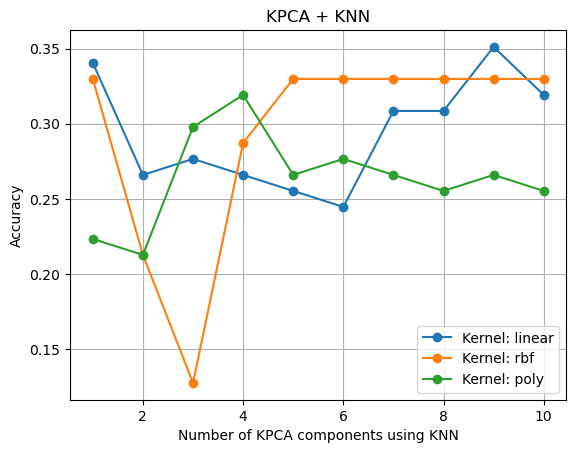

In [9]:
# KPCA + KNN
kernels = ['linear', 'rbf', 'poly']
results = {kernel: [] for kernel in kernels}
best_accuracy = {kernel: 0 for kernel in kernels}
best_n_components = {kernel: 0 for kernel in kernels}

for kernel in kernels:
    for i in range(10):
        kpca = KernelPCA(n_components=i+1, kernel=kernel, eigen_solver='randomized', max_iter=1000)
        train_reduced = kpca.fit_transform(X_train)
        test_reduced = kpca.transform(X_test)
        # train classifier
        KNN = KNeighborsClassifier()
        KNN.fit(train_reduced, y_train)
        y_pred = KNN.predict(test_reduced)
        accuracy = accuracy_score(y_test, y_pred)
        results[kernel].append(accuracy)
    
        if accuracy > best_accuracy[kernel]:
            best_accuracy[kernel] = accuracy
            best_n_components[kernel] = i+1
    
    plt.plot(range(1, 11), results[kernel], marker='o', label=f'Kernel: {kernel}')
    print(f"Best number of components for {kernel} kernel: {best_n_components[kernel]} with accuracy: {best_accuracy[kernel]:.4f}")


plt.grid()
plt.title('KPCA + KNN')
plt.xlabel('Number of KPCA components using KNN')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# top 10 features (KNN)
KNN = KNeighborsClassifier()
KNN.fit(Train_top10, y_train)
y_pred = KNN.predict(Test_top10)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.2872340425531915


# SVM <a class="anchor" id="3-2"></a>

In [11]:
# whole data (SVM)
SVM = SVC()
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.32978723404255317


Best number of components: 3 with accuracy: 0.3511


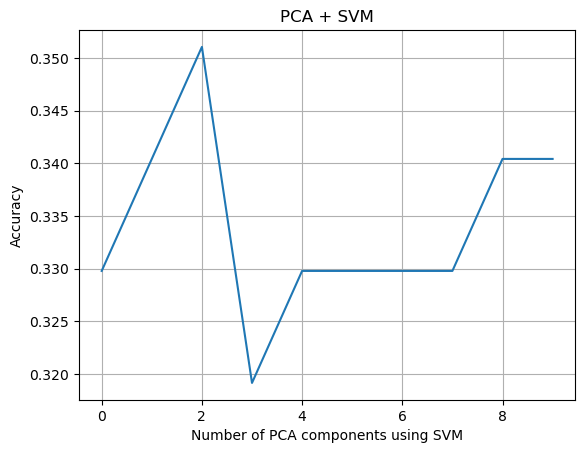

In [12]:
# PCA + SVM
results = []
best_accuracy = 0
best_n_components = 0

for i in range(10):
    pca = PCA(n_components=i+1)
    train_reduced = pca.fit_transform(X_train)
    test_reduced = pca.transform(X_test)
    # train classifier
    SVM = SVC()
    SVM.fit(train_reduced, y_train)
    y_pred = SVM.predict(test_reduced)
    accuracy = accuracy_score(y_test, y_pred)
    results.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components = i+1

plt.plot(results)
plt.grid()
plt.title('PCA + SVM')
plt.xlabel('Number of PCA components using SVM')
plt.ylabel('Accuracy')

print(f"Best number of components: {best_n_components} with accuracy: {best_accuracy:.4f}")

Best number of components for linear kernel: 3 with accuracy: 0.3511
Best number of components for rbf kernel: 1 with accuracy: 0.3298
Best number of components for poly kernel: 3 with accuracy: 0.3511


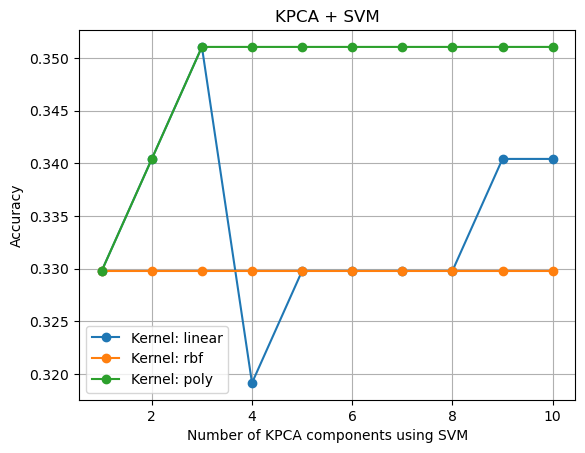

In [13]:
# KPCA + SVM
kernels = ['linear', 'rbf', 'poly']
results = {kernel: [] for kernel in kernels}
best_accuracy = {kernel: 0 for kernel in kernels}
best_n_components = {kernel: 0 for kernel in kernels}

for kernel in kernels:
    for i in range(10):
        kpca = KernelPCA(n_components=i+1, kernel=kernel, eigen_solver='randomized', max_iter=1000)
        train_reduced = kpca.fit_transform(X_train)
        test_reduced = kpca.transform(X_test)
        # train classifier
        SVM = SVC()
        SVM.fit(train_reduced, y_train)
        y_pred = SVM.predict(test_reduced)
        accuracy = accuracy_score(y_test, y_pred)
        results[kernel].append(accuracy)
        
        if accuracy > best_accuracy[kernel]:
            best_accuracy[kernel] = accuracy
            best_n_components[kernel] = i+1
        
    plt.plot(range(1, 11), results[kernel], marker='o', label=f'Kernel: {kernel}')
    print(f"Best number of components for {kernel} kernel: {best_n_components[kernel]} with accuracy: {best_accuracy[kernel]:.4f}")

plt.grid()
plt.title('KPCA + SVM')
plt.xlabel('Number of KPCA components using SVM')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# top 10 features (SVM)
SVM = SVC()
SVM.fit(Train_top10, y_train)
y_pred = SVM.predict(Test_top10)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.32978723404255317


# LDA <a class="anchor" id="3-3"></a>

In [15]:
# whole data (LDA)
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)
y_pred = LDA.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.26595744680851063


Best number of components: 3 with accuracy: 0.3511


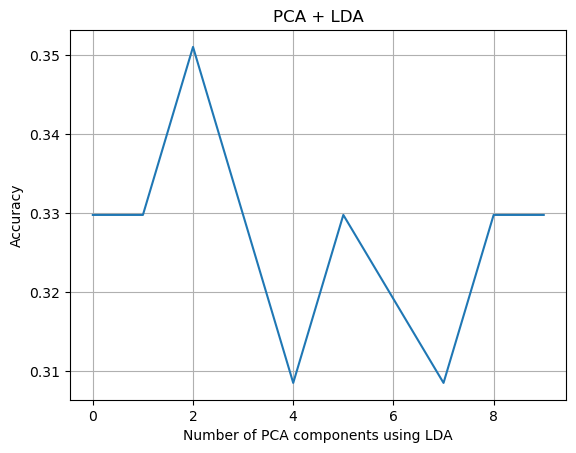

In [16]:
# PCA + LDA
results = []
best_accuracy = 0
best_n_components = 0

for i in range(10):
    pca = PCA(n_components=i+1)
    train_reduced = pca.fit_transform(X_train)
    test_reduced = pca.transform(X_test)
    # train classifier
    LDA = LinearDiscriminantAnalysis()
    LDA.fit(train_reduced, y_train)
    y_pred = LDA.predict(test_reduced)
    accuracy = accuracy_score(y_test, y_pred)
    results.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components = i+1

plt.plot(results)
plt.grid()
plt.title('PCA + LDA')
plt.xlabel('Number of PCA components using LDA')
plt.ylabel('Accuracy')

print(f"Best number of components: {best_n_components} with accuracy: {best_accuracy:.4f}")

Best number of components for linear kernel: 3 with accuracy: 0.3511
Best number of components for rbf kernel: 1 with accuracy: 0.3298
Best number of components for poly kernel: 1 with accuracy: 0.3298


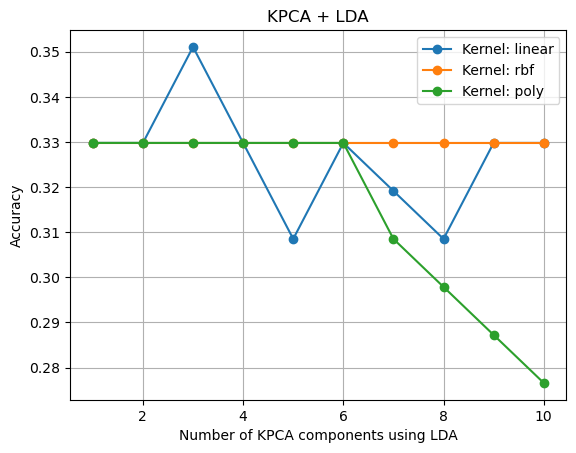

In [17]:
# KPCA + LDA
kernels = ['linear', 'rbf', 'poly']
results = {kernel: [] for kernel in kernels}
best_accuracy = {kernel: 0 for kernel in kernels}
best_n_components = {kernel: 0 for kernel in kernels}

for kernel in kernels:
    for i in range(10):
        kpca = KernelPCA(n_components=i+1, kernel=kernel, eigen_solver='randomized', max_iter=1000)
        train_reduced = kpca.fit_transform(X_train)
        test_reduced = kpca.transform(X_test)
        # train classifier
        LDA = LinearDiscriminantAnalysis()
        LDA.fit(train_reduced, y_train)
        y_pred = LDA.predict(test_reduced)
        accuracy = accuracy_score(y_test, y_pred)
        results[kernel].append(accuracy)
        
        if accuracy > best_accuracy[kernel]:
            best_accuracy[kernel] = accuracy
            best_n_components[kernel] = i+1
        
    plt.plot(range(1, 11), results[kernel], marker='o', label=f'Kernel: {kernel}')
    print(f"Best number of components for {kernel} kernel: {best_n_components[kernel]} with accuracy: {best_accuracy[kernel]:.4f}")

plt.grid()
plt.title('KPCA + LDA')
plt.xlabel('Number of KPCA components using LDA')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# top 10 features (LDA)
LDA = LinearDiscriminantAnalysis()
LDA.fit(Train_top10, y_train)
y_pred = LDA.predict(Test_top10)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.3191489361702128


# Naïve Bayes <a class="anchor" id="3-4"></a>

In [19]:
# whole data (NB)
NB = GaussianNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.13829787234042554


Best number of components: 1 with accuracy: 0.1383


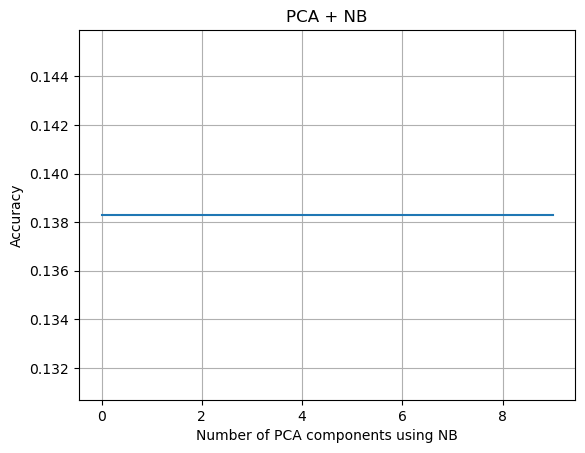

In [20]:
# PCA + NB
results = []
best_accuracy = 0
best_n_components = 0

for i in range(10):
    pca = PCA(n_components=i+1)
    train_reduced = pca.fit_transform(X_train)
    test_reduced = pca.transform(X_test)
    # train classifier
    NB = GaussianNB()
    NB.fit(X_train, y_train)
    y_pred = NB.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components = i+1

plt.plot(results)
plt.grid()
plt.title('PCA + NB')
plt.xlabel('Number of PCA components using NB')
plt.ylabel('Accuracy')

print(f"Best number of components: {best_n_components} with accuracy: {best_accuracy:.4f}")

Best number of components for linear kernel: 1 with accuracy: 0.1383
Best number of components for rbf kernel: 1 with accuracy: 0.1383
Best number of components for poly kernel: 1 with accuracy: 0.1383


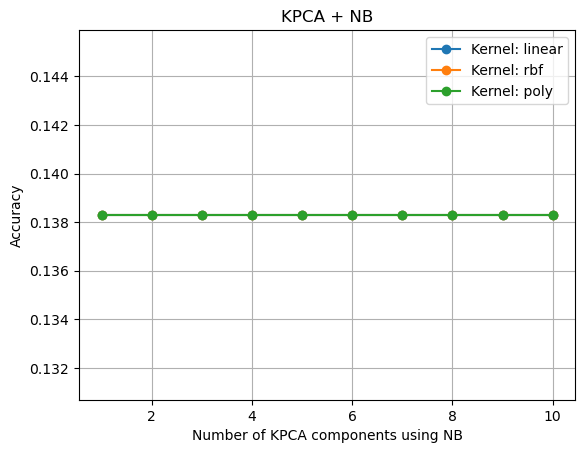

In [21]:
# KPCA + NB
kernels = ['linear', 'rbf', 'poly']
results = {kernel: [] for kernel in kernels}
best_accuracy = {kernel: 0 for kernel in kernels}
best_n_components = {kernel: 0 for kernel in kernels}

for kernel in kernels:
    for i in range(10):
        kpca = KernelPCA(n_components=i+1, kernel=kernel, eigen_solver='randomized', max_iter=1000)
        train_reduced = kpca.fit_transform(X_train)
        test_reduced = kpca.transform(X_test)
        # train classifier
        NB = GaussianNB()
        NB.fit(X_train, y_train)
        y_pred = NB.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[kernel].append(accuracy)
        
        if accuracy > best_accuracy[kernel]:
            best_accuracy[kernel] = accuracy
            best_n_components[kernel] = i+1
        
    plt.plot(range(1, 11), results[kernel], marker='o', label=f'Kernel: {kernel}')
    print(f"Best number of components for {kernel} kernel: {best_n_components[kernel]} with accuracy: {best_accuracy[kernel]:.4f}")

plt.grid()
plt.title('KPCA + NB')
plt.xlabel('Number of KPCA components using NB')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
# top 10 features (NB)
NB = GaussianNB()
NB.fit(Train_top10, y_train)
y_pred = NB.predict(Test_top10)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.23404255319148937


# Bayes (from scratch) <a class="anchor" id="3-5"></a>

In [23]:
class BayesClassifier():
    def __init__(self):
        classes=None
        priors=None
        means=None
        covx=None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n = X.shape[0]
        d = X.shape[1]
        self.priors = np.zeros(n)
        self.means = np.zeros((n, d))
        self.covx = np.zeros((n, d, d))

        for i, c in enumerate(self.classes):
            Di = X[y == c]
            ni = Di.shape[0]
            self.priors[i] = ni / n # prior probability
            self.means[i] = np.mean(Di, axis=0) # mean
            zi = Di - self.means[i] # centered
            self.covx[i] = np.cov(zi, rowvar=False) # covariance matrix

    def gaussian(self, x, mean, cov):
        d = len(x)
        det = np.linalg.det(cov)
        const = (1 / np.sqrt(2 * np.pi) ** d * np.sqrt(det))
        diff = x - mean
        inv = np.linalg.inv(cov)
        return const * np.exp(-0.5 * (diff.T @ inv @ diff))
                              
    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for i, c in enumerate(self.classes):
                likelihood = self.gaussian(x, self.means[i], self.covx[i])
                posterior = likelihood * self.priors[i]
                posteriors.append(posterior)
                
            y_hat = self.classes[np.argmax(posteriors)]
            y_pred.append(y_hat)
        return np.array(y_pred)

Best number of components: 1 with accuracy: 0.3298


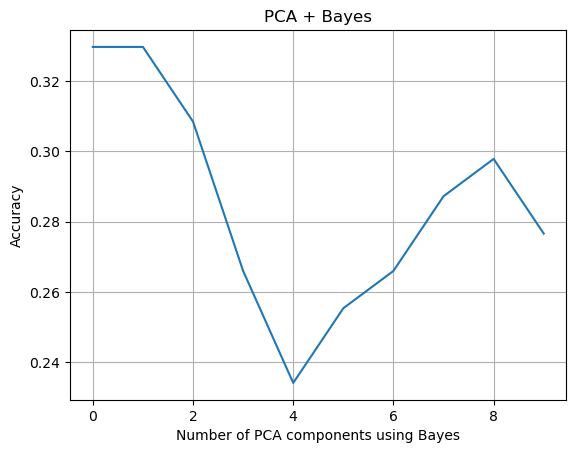

In [24]:
# PCA + Bayes
results = []
best_accuracy = 0
best_n_components = 0

for i in range(10):
    pca = PCA(n_components=i+1)
    train_reduced = pca.fit_transform(X_train)
    test_reduced = pca.transform(X_test)
    # train classifier
    Bayes = BayesClassifier()
    Bayes.fit(train_reduced, y_train)
    y_pred = Bayes.predict(test_reduced)
    accuracy = accuracy_score(y_test, y_pred)
    results.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_n_components = i+1

plt.plot(results)
plt.grid()
plt.title('PCA + Bayes')
plt.xlabel('Number of PCA components using Bayes')
plt.ylabel('Accuracy')

print(f"Best number of components: {best_n_components} with accuracy: {best_accuracy:.4f}")

Best number of components for linear kernel: 1 with accuracy: 0.3298
Best number of components for rbf kernel: 1 with accuracy: 0.3298
Best number of components for poly kernel: 1 with accuracy: 0.3298


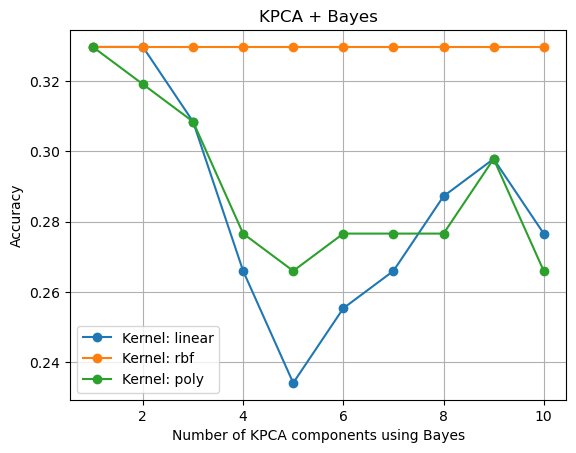

In [25]:
# KPCA + Bayes
kernels = ['linear', 'rbf', 'poly']
results = {kernel: [] for kernel in kernels}
best_accuracy = {kernel: 0 for kernel in kernels}
best_n_components = {kernel: 0 for kernel in kernels}

for kernel in kernels:
    for i in range(10):
        kpca = KernelPCA(n_components=i+1, kernel=kernel, eigen_solver='randomized', max_iter=1000)
        train_reduced = kpca.fit_transform(X_train)
        test_reduced = kpca.transform(X_test)
        # train classifier
        Bayes = BayesClassifier()
        Bayes.fit(train_reduced, y_train)
        y_pred = Bayes.predict(test_reduced)
        accuracy = accuracy_score(y_test, y_pred)
        results[kernel].append(accuracy)
        
        if accuracy > best_accuracy[kernel]:
            best_accuracy[kernel] = accuracy
            best_n_components[kernel] = i+1
        
    plt.plot(range(1, 11), results[kernel], marker='o', label=f'Kernel: {kernel}')
    print(f"Best number of components for {kernel} kernel: {best_n_components[kernel]} with accuracy: {best_accuracy[kernel]:.4f}")

plt.grid()
plt.title('KPCA + Bayes')
plt.xlabel('Number of KPCA components using Bayes')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
# top 10 features (Bayes) 
Bayes = BayesClassifier()
Bayes.fit(Train_top10, y_train)
y_pred = Bayes.predict(Test_top10)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.2765957446808511


## 4. Clustering Experiment <a class="anchor" id="4"></a>

### 4.a Clustering `n_clusters=5` (3 methods) <a class="anchor" id="4-a"></a>

The code below clusters the data points into 5 clusters using Kmeans, Kernel Kmeans, and Expectation Maximization.

### Kmeans

In [27]:
# Kmeans
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)

C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### Kernel Kmeans


According to the source from Medium on understanding K-Means clustering and kernel methods (https://medium.com/udemy-engineering/understanding-k-means-clustering-and-kernel-methods-afad4eec3c11), spectral clustering is described as a relaxed version of kernel K-Means. In this implementation, spectral clustering was applied using the SpectralClustering module from Scikit-learn with various kernel types (RBF, polynomial, linear). Simultaneously, a custom kernel K-Means implementation was developed and evaluated using the adjusted Rand score to compare clustering performance against ground truth labels.

**Scikit-learn**

In [55]:
# Compute the kernel matrices
rbf_kernel = pairwise_kernels(X, metric='rbf')
poly_kernel = pairwise_kernels(X, metric='polynomial')
linear_kernel = pairwise_kernels(X, metric='linear')

# Spectral clustering with RBF kernel
spectral_rbf = SpectralClustering(n_clusters=5, affinity='precomputed', random_state=42)
spectral_rbf_labels = spectral_rbf.fit_predict(rbf_kernel)

# Spectral clustering with polynomial kernel
spectral_poly = SpectralClustering(n_clusters=5, affinity='precomputed', random_state=42)
spectral_poly_labels = spectral_poly.fit_predict(poly_kernel)

# Spectral clustering with linear kernel
spectral_linear = SpectralClustering(n_clusters=5, affinity='precomputed', random_state=42)
spectral_linear_labels = spectral_linear.fit_predict(linear_kernel)

C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the 

**Custom Kernel Kmeans**

In [41]:
def kernel_kmeans(X, n_clusters, kernel="rbf", max_iter=1000, random_state=42):
    if random_state:
        np.random.seed(random_state)
        
    # compute kernel matrix
    K = pairwise_kernels(X, metric=kernel)
    
    # initialize cluster centers randomly
    n_samples = X.shape[0]
    centers = np.random.choice(n_samples, n_clusters, replace=False)
    labels = np.zeros(n_samples, dtype=int)
    
    for _ in range(max_iter):
        # assign labels based on closest center
        distances = np.zeros((n_samples, n_clusters))
        for i, center in enumerate(centers):
            distances[:, i] = K[center, center] - 2 * K[:, center] + np.diag(K)
        
        new_labels = np.argmin(distances, axis=1)
        
        # check if labels don't change -> convergence reached
        if np.all(labels == new_labels):
            break
        labels = new_labels
        
        # update centers
        for i in range(n_clusters):
            cluster_points = np.where(labels == i)[0]
            if len(cluster_points) > 0:
                centers[i] = cluster_points[np.argmax(np.sum(K[cluster_points][:, cluster_points], axis=1))]
    
    return labels

In [58]:
# Kernel Kmeans Use " RBF, polynomial, and Linear"
rbf_labels = kernel_kmeans(X, 5, kernel="rbf")
poly_labels = kernel_kmeans(X, 5, kernel="poly")
linear_labels = kernel_kmeans(X, 5, kernel="linear")

**Comparison**

The adjusted Rand scores compare the clustering results of Spectral clustering and custom kernel K-Means methods using different kernel types (linear, polynomial, RBF) against the true labels (y). A positive score indicates better-than-random agreement with the true labels, while a score near zero or negative suggests weaker agreement. In this comparison, both methods show varying degrees of alignment with the ground truth labels across different kernel types. For instance, Spectral clustering with linear and RBF kernels exhibits slight disagreement (scores of 0.003696 and -0.002659, respectively), while custom kernel K-Means demonstrates comparable performance with scores of 0.002009 (linear), 0.005631 (polynomial), and 0.002429 (RBF). 

In [61]:
spectral_scores = []

rbf_score = adjusted_rand_score(y, spectral_rbf_labels)
spectral_scores.append({'Kernel': 'rbf', 'Method': 'Spectral', 'ARI': rbf_score})
poly_score = adjusted_rand_score(y, spectral_poly_labels)
spectral_scores.append({'Kernel': 'poly', 'Method': 'Spectral', 'ARI': poly_score})
linear_score = adjusted_rand_score(y, spectral_linear_labels)
spectral_scores.append({'Kernel': 'linear', 'Method': 'Spectral', 'ARI': linear_score})

kernel_kmeans_scores = []

rbf_custom_score = adjusted_rand_score(y, rbf_labels)
kernel_kmeans_scores.append({'Kernel': 'rbf', 'Method': 'Custom', 'ARI': rbf_custom_score})
poly_custom_score = adjusted_rand_score(y, poly_labels)
kernel_kmeans_scores.append({'Kernel': 'poly', 'Method': 'Custom', 'ARI': poly_custom_score})
linear_custom_score = adjusted_rand_score(y, linear_labels)
kernel_kmeans_scores.append({'Kernel': 'linear', 'Method': 'Custom', 'ARI': linear_custom_score})

spectral_df = pd.DataFrame(spectral_scores)
kernel_kmeans_df = pd.DataFrame(kernel_kmeans_scores)
spectral_pivot = spectral_df.pivot(index='Kernel', columns='Method', values='ARI')
kernel_kmeans_pivot = kernel_kmeans_df.pivot(index='Kernel', columns='Method', values='ARI')
comparison_df = pd.merge(spectral_pivot, kernel_kmeans_pivot, on='Kernel', suffixes=('_Spectral', '_Custom'))

display(comparison_df)

Method,Spectral,Custom
Kernel,,
linear,0.003696,0.002009
poly,-0.000678,0.005631
rbf,-0.002659,0.002429


### Expectation Maximization

In [31]:
# Expectation Maximization
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(X)

C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


### 4.b Results, evaluation metrics, and visualization <a class="anchor" id="4-b"></a>

This section presents the clustering results using KMeans, RBF Kernel KMeans, Polynomial Kernel KMeans, Linear Kernel KMeans, and EM Gaussian Mixture Models (GMM). The results DataFrame captures the clustering labels for each method. Evaluation metrics including Silhouette Score, Calinski-Harabasz Index, and Davies-Bouldin Index are computed to assess clustering performance. Visualizations using PCA illustrate how well each method segregates data points into clusters in a 2D space.

In [32]:
# results df
results = pd.DataFrame({
    'KMeans': kmeans_labels,
    'RBF_Kernel_KMeans': rbf_labels,
    'Poly_Kernel_KMeans': poly_labels,
    'Linear_Kernel_KMeans': linear_labels,
    'EM_GMM': gmm_labels
})

display(results.head())

,KMeans,RBF_Kernel_KMeans,Poly_Kernel_KMeans,Linear_Kernel_KMeans,EM_GMM
0,4,0,0,1,3
1,2,0,0,1,0
2,1,0,0,1,2
3,4,0,0,1,0
4,2,0,0,0,0


In [33]:
# Compare the clustering results using appropriate evaluation metrics and visualizations.
metrics = {}

# Silhouette Score - measures how similar an object is to its own cluster compare to other clusters
# -1 to 1, where 1 means well-separated clusters
metrics['Silhouette'] = {
    'KMeans': silhouette_score(X, kmeans_labels),
    'RBF_Kernel_KMeans': silhouette_score(X, rbf_labels),
    'Poly_Kernel_KMeans': silhouette_score(X, poly_labels),
    'Linear_Kernel_KMeans': silhouette_score(X, linear_labels),
    'EM_GMM': silhouette_score(X, gmm_labels)
}

# Calinski-Harabasz Index - measures the ratio of the sum of between-cluster dispersion and within-cluster dispersion
# higher value == better-defined clusters
metrics['Calinski_Harabasz'] = {
    'KMeans': calinski_harabasz_score(X, kmeans_labels),
    'RBF_Kernel_KMeans': calinski_harabasz_score(X, rbf_labels),
    'Poly_Kernel_KMeans': calinski_harabasz_score(X, poly_labels),
    'Linear_Kernel_KMeans': calinski_harabasz_score(X, linear_labels),
    'EM_GMM': calinski_harabasz_score(X, gmm_labels)
}

# Davies-Bouldin Index - measures the average similarity ratio of each cluster with its most similar cluster
# lower value == better clustering
metrics['Davies_Bouldin'] = {
    'KMeans': davies_bouldin_score(X, kmeans_labels),
    'RBF_Kernel_KMeans': davies_bouldin_score(X, rbf_labels),
    'Poly_Kernel_KMeans': davies_bouldin_score(X, poly_labels),
    'Linear_Kernel_KMeans': davies_bouldin_score(X, linear_labels),
    'EM_GMM': davies_bouldin_score(X, gmm_labels)
}

metrics_df = pd.DataFrame(metrics)
display(metrics_df)

,Silhouette,Calinski_Harabasz,Davies_Bouldin
KMeans,0.233497,171.892529,1.154943
RBF_Kernel_KMeans,-0.338115,2.264168,1.474477
Poly_Kernel_KMeans,0.390372,40.906727,0.595341
Linear_Kernel_KMeans,0.136618,68.983546,1.007559
EM_GMM,0.234576,168.564894,1.345288


In the table above, Polynomial Kernel KMeans shows the highest Silhouette score, indicating well-separated clusters, while RBF Kernel KMeans has a negative Silhouette score, suggesting cluster overlap. KMeans and EM GMM achieve high Calinski-Harabasz scores, indicating well-defined clusters. Davies-Bouldin scores are lowest for Polynomial Kernel KMeans, suggesting clearer cluster structures compared to other methods

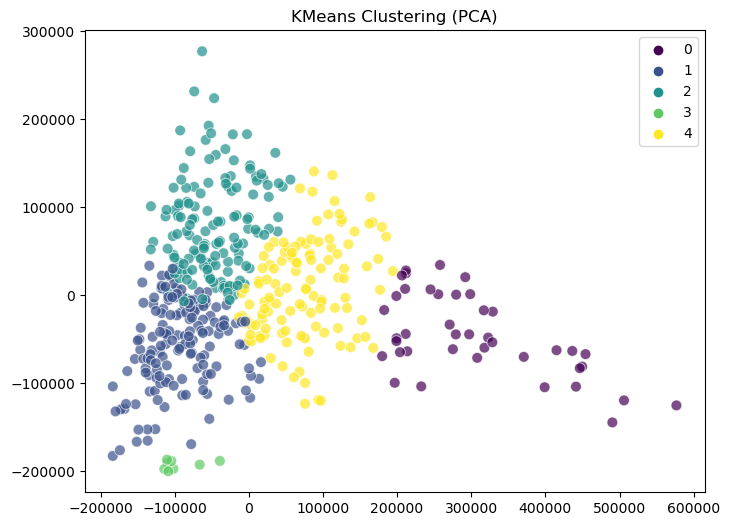

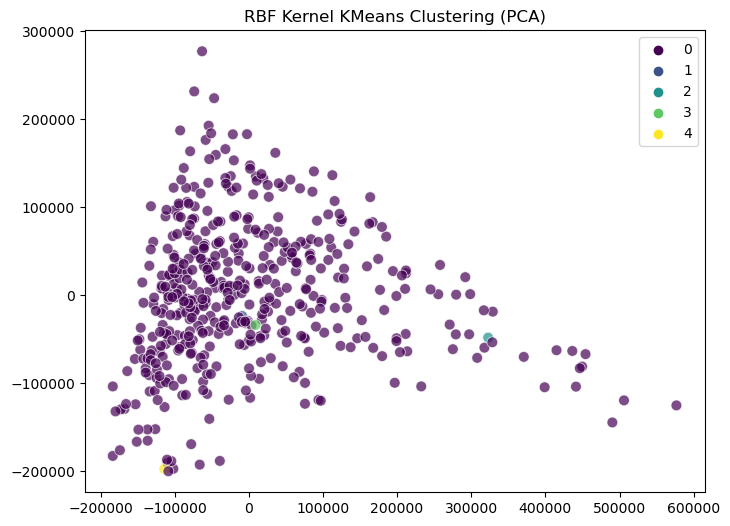

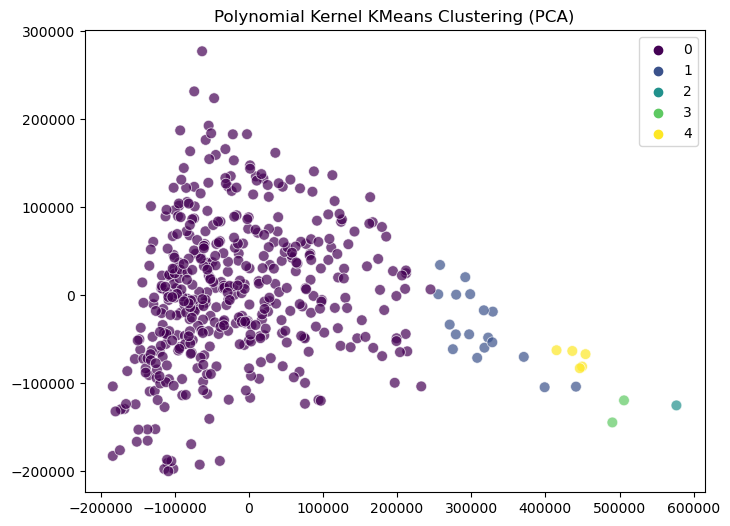

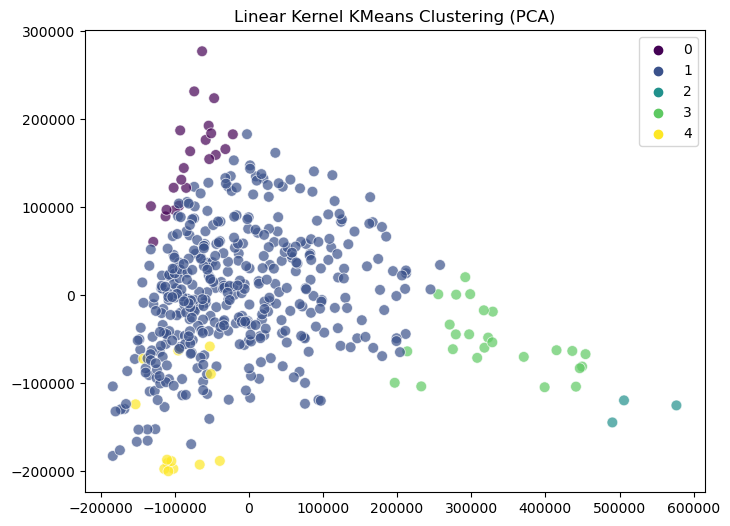

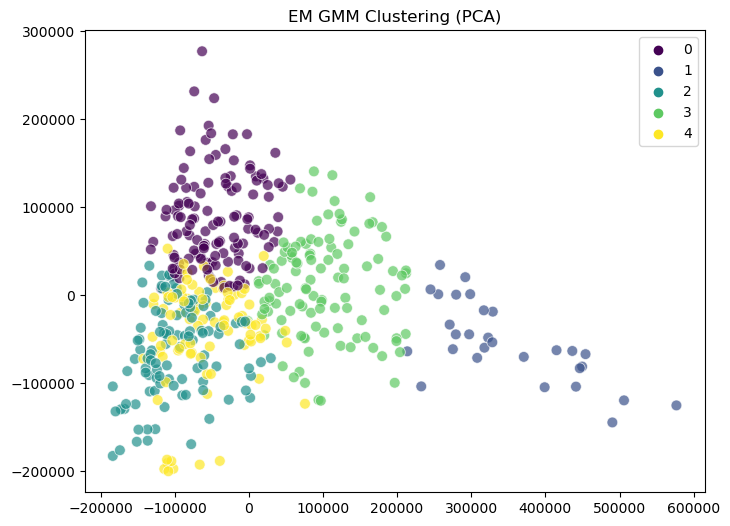

In [34]:
# I'm using PCA to reduce dimensionality and visualize the clusters in 2D space
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# func to plot clusters
def plot_clusters(X, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='viridis', s=60, alpha=0.7)
    plt.title(title)
    plt.show()

plot_clusters(X_pca, kmeans_labels, 'KMeans Clustering (PCA)')
plot_clusters(X_pca, rbf_labels, 'RBF Kernel KMeans Clustering (PCA)')
plot_clusters(X_pca, poly_labels, 'Polynomial Kernel KMeans Clustering (PCA)')
plot_clusters(X_pca, linear_labels, 'Linear Kernel KMeans Clustering (PCA)')
plot_clusters(X_pca, gmm_labels, 'EM GMM Clustering (PCA)')

## 5. Clustering `n_clusters=2` (3 methods) <a class="anchor" id="5"></a>

The code below clusters the data points into 2 clusters using Kmeans, Kernel Kmeans, and Expectation Maximization.

In [62]:
# Kmeans Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Kernel Kmeans Use " RBF, polynomial, and Linear"
rbf_labels = kernel_kmeans(X, 2, kernel="rbf")
poly_labels = kernel_kmeans(X, 2, kernel="poly")
linear_labels = kernel_kmeans(X, 2, kernel="linear")

# Expectation Maximization (Gaussian Mixture Model)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X)

results = pd.DataFrame({
    'KMeans': kmeans_labels,
    'RBF_Kernel_KMeans': rbf_labels,
    'Poly_Kernel_KMeans': poly_labels,
    'Linear_Kernel_KMeans': linear_labels,
    'EM_GMM': gmm_labels
})

display(results.head())

C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\agodo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,KMeans,RBF_Kernel_KMeans,Poly_Kernel_KMeans,Linear_Kernel_KMeans,EM_GMM
0,1,0,1,1,1
1,0,0,1,1,0
2,0,0,1,1,0
3,0,0,1,1,0
4,0,0,1,1,0


## 6. Test on Five-Stage Classification <a class="anchor" id="6"></a>

The code below finds the cluster with the smallest number of features for each clustering method, and splits the data into train and test sets.

In [36]:
# func to find group with fewer features
def find_smaller_group(labels):
    group1_size = sum(labels == 0)
    group2_size = sum(labels == 1)
    return 0 if group1_size < group2_size else 1

kmeans_group = find_smaller_group(kmeans_labels)
rbf_group = find_smaller_group(rbf_labels)
poly_group = find_smaller_group(poly_labels)
linear_group = find_smaller_group(linear_labels)
gmm_group = find_smaller_group(gmm_labels)

# extract them
X_kmeans = X[kmeans_labels == kmeans_group]
X_rbf = X[rbf_labels == rbf_group]
X_poly = X[poly_labels == poly_group]
X_linear = X[linear_labels == linear_group]
X_gmm = X[gmm_labels == gmm_group]

y_kmeans = y[kmeans_labels == kmeans_group]
y_rbf = y[rbf_labels == rbf_group]
y_poly = y[poly_labels == poly_group]
y_linear = y[linear_labels == linear_group]
y_gmm = y[gmm_labels == gmm_group]

# split for each clustering method
X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans = train_test_split(X_kmeans, y_kmeans, test_size=0.2, random_state=42)
X_train_rbf, X_test_rbf, y_train_rbf, y_test_rbf = train_test_split(X_rbf, y_rbf, test_size=0.2, random_state=42)
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)
X_train_gmm, X_test_gmm, y_train_gmm, y_test_gmm = train_test_split(X_gmm, y_gmm, test_size=0.2, random_state=42)

The code below, evaluates SVM, KNN, and NB classifiers on test data split from clusters identified by various methods including KMeans, RBF Kernel KMeans, Polynomial Kernel KMeans, Linear Kernel KMeans, and EM GMM. Results are summarized in results_df, showing accuracy scores across classifiers and clustering methods.

In [37]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    # SVM
    svm = SVC()
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_test)
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    
    # KNN
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    
    # Naive Bayes
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    y_pred_nb = nb.predict(X_test)
    nb_accuracy = accuracy_score(y_test, y_pred_nb)
    
    return svm_accuracy, knn_accuracy, nb_accuracy

# eval for each clustering method
results = {
    'KMeans': train_and_evaluate(X_train_kmeans, X_test_kmeans, y_train_kmeans, y_test_kmeans),
    'RBF_Kernel_KMeans': train_and_evaluate(X_train_rbf, X_test_rbf, y_train_rbf, y_test_rbf),
    'Poly_Kernel_KMeans': train_and_evaluate(X_train_poly, X_test_poly, y_train_poly, y_test_poly),
    'Linear_Kernel_KMeans': train_and_evaluate(X_train_linear, X_test_linear, y_train_linear, y_test_linear),
    'EM_GMM': train_and_evaluate(X_train_gmm, X_test_gmm, y_train_gmm, y_test_gmm)
}

# disp the results
results_df = pd.DataFrame(results, index=['SVM', 'KNN', 'NB'])
print("Accuracy score:")
display(results_df)

Accuracy score:


,KMeans,RBF_Kernel_KMeans,Poly_Kernel_KMeans,Linear_Kernel_KMeans,EM_GMM
SVM,0.272727,0.333333,0.5,0.285714,0.272727
KNN,0.272727,0.307692,0.5,0.357143,0.272727
NB,0.363636,0.179487,0.5,0.250000,0.363636


## Conclusion <a class="anchor" id="last"></a>

In this notebook, we explored various techniques for analyzing and classifying medical image data from the `Colon.csv` dataset.

Firstly, we prepared the data by splitting it into training and testing sets (80/20%). We then applied Principal Component Analysis (PCA) and Kernel PCA using different kernels to reduce the dimensionality of the dataset while preserving its variance structure.

Next, we conducted covariance matrix analysis to identify the top 10 features with the highest covariance, which were subsequently used for training classifiers. These classifiers included K-Nearest Neighbors (KNN), Support Vector Machines (SVM), Linear Discriminant Analysis (LDA), Naïve Bayes, and a custom implementation of Bayes classifier.

Throughout the classification experiments, we evaluated each classifier's performance on the original data, PCA-transformed data, KPCA-transformed data with various kernels, and the selected top 10 features. The results showed varied performance across different methods, with SVM and LDA achieving the highest accuracy of 35.11% when using PCA-reduced data.

Finally, we used K-Means, Kernel K-Means, and Expectation Maximization as clustering methods aimed to group similar data points into five clusters. We then used the same three methods to cluster the data points into 2 clusters, and evaluating SVM, KNN, and Naive Bayes on the cluster with the smallest number of features.